# R4 on Plant Phenotyping Dataset

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import PlantNet
from models.robust_regularizer import input_gradient_interval_regularizer
from models.pipeline import train_model_with_pgd_robust_input_grad, train_model_with_certified_input_grad, test_model_accuracy, test_delta_input_robustness
from datasets import plant

# Get the dataloaders 

In [2]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 50

cuda:1


In [3]:
# isic_save_path = "/vol/bitbucket/mg2720/isic/isic.pt"
# [isic_input_tensors, isic_labels] = torch.load(isic_save_path, mmap=True)
SPLIT_ROOT = "/vol/bitbucket/mg2720/plant/rgb_dataset_splits"
DATA_ROOT = "/vol/bitbucket/mg2720/plant/rgb_data"
MASKS_FILE = "/vol/bitbucket/mg2720/plant/mask/preprocessed_masks.pyu"

plant_train_2 = plant.PlantDataset(SPLIT_ROOT, DATA_ROOT, MASKS_FILE, 2, True)
plant_test_2 = plant.PlantDataset(SPLIT_ROOT, DATA_ROOT, MASKS_FILE, 2, False)
print(len(plant_train_2), len(plant_test_2))

1806 604


tensor(1.)


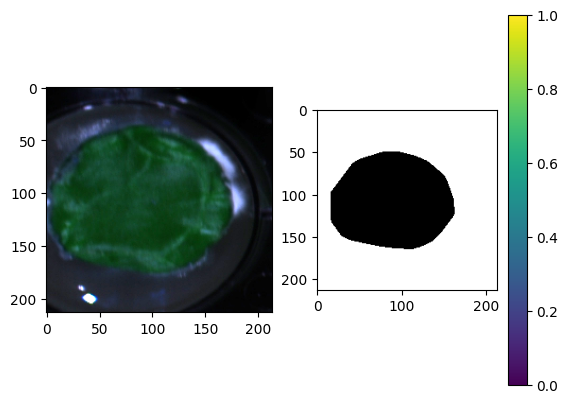

tensor(1.)


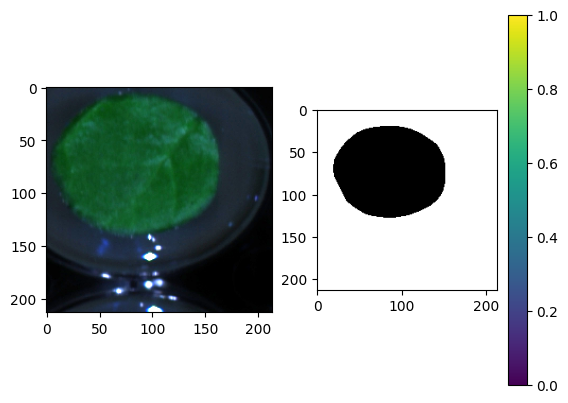

tensor(1.)


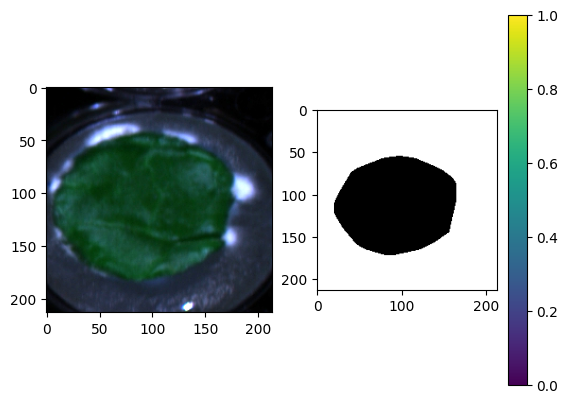

tensor(1.)


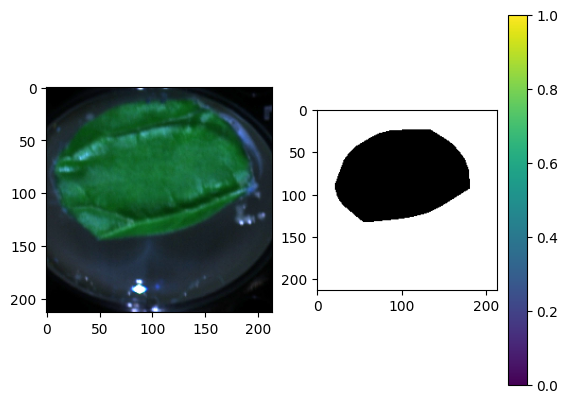

tensor(0.)


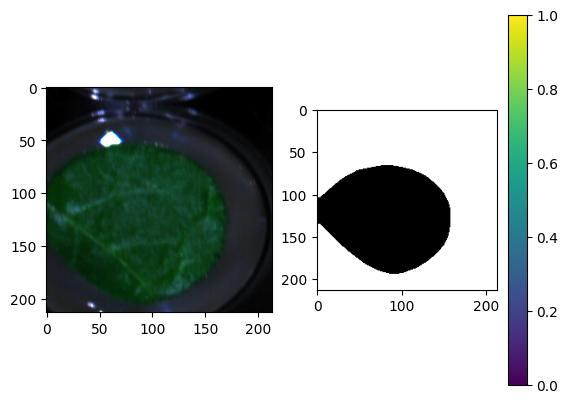

In [4]:
img, img_label, img_mask = None, None, None
rand_5 = torch.randint(0, len(plant_train_2), (5,))
for i in rand_5:
    img, img_label, img_mask = plant_train_2[i]
    print(img_label)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img.permute(1, 2, 0).squeeze().numpy())
    im_mask = ax[1].imshow(img_mask.permute(1, 2, 0).squeeze().numpy())
    fig.colorbar(im_mask, ax=ax[1])
    plt.show()

In [5]:
dl_train = plant.get_dataloader(plant_train_2, batch_size)
dl_test = plant.get_dataloader(plant_test_2, 10)

In [6]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, has_conv, curr_device):
    channel_to_view = 1
    batch_input, batch_labels, batch_mask = batch_input.to(curr_device), batch_labels.to(curr_device), batch_mask.to(curr_device)
    model.to(curr_device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4",
        batch_masks=batch_mask, has_conv=has_conv, device=curr_device
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].permute(1, 2, 0).cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeeze(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    cbu = fig.colorbar(im_dx_u, ax=ax[1][1])
    cbu.ax.invert_yaxis()
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [7]:
# define model, dataset and optimizer
num_epochs = 5
lr = 0.001
restarts = 1
epsilon = 0.01
# k is a coefficient for the regularization term
k = 0.2
model = PlantNet(3, 1)
criterion = torch.nn.BCELoss()
gpu_ids = [i for i in range(torch.cuda.device_count())]
print(gpu_ids)
model = torch.nn.DataParallel(model, device_ids=gpu_ids)
model = model.to(device)

[0, 1]


44
Batch input shape: torch.Size([50, 3, 213, 213]), batch mask shape: torch.Size([50, 3, 213, 213])
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


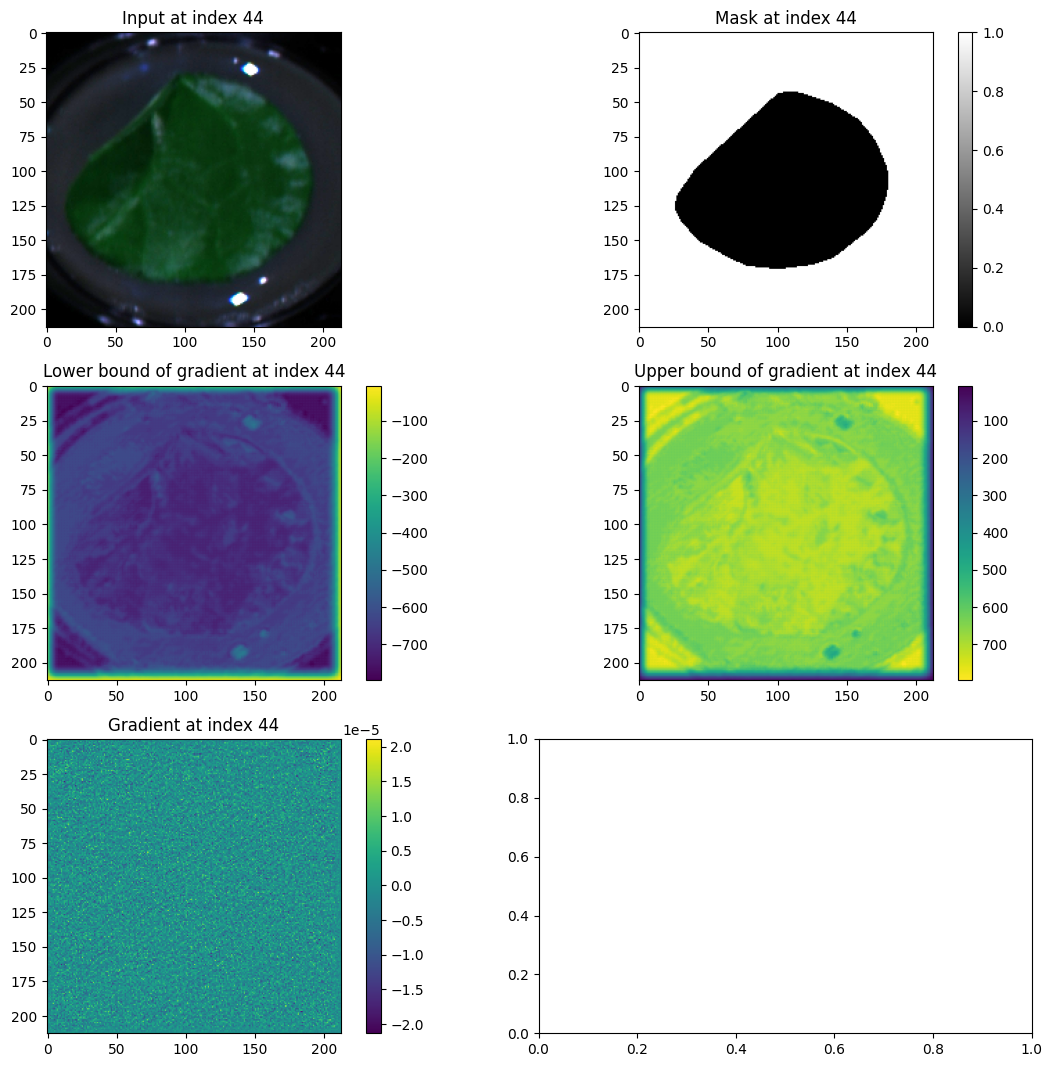

In [8]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
print(idx_to_visualize)
init_batch_train_with_masks = next(iter(dl_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize, True, device)

## Experiments 

In [9]:
DELTA_INPUT_ROBUSTNESS_PARAM = 1

### Standard Training

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 5/5 [01:37<00:00, 19.43s/it, loss=0.398, reg=0]


--- Model accuracy ---
Nominal = 0.87
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 3.35e+03
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


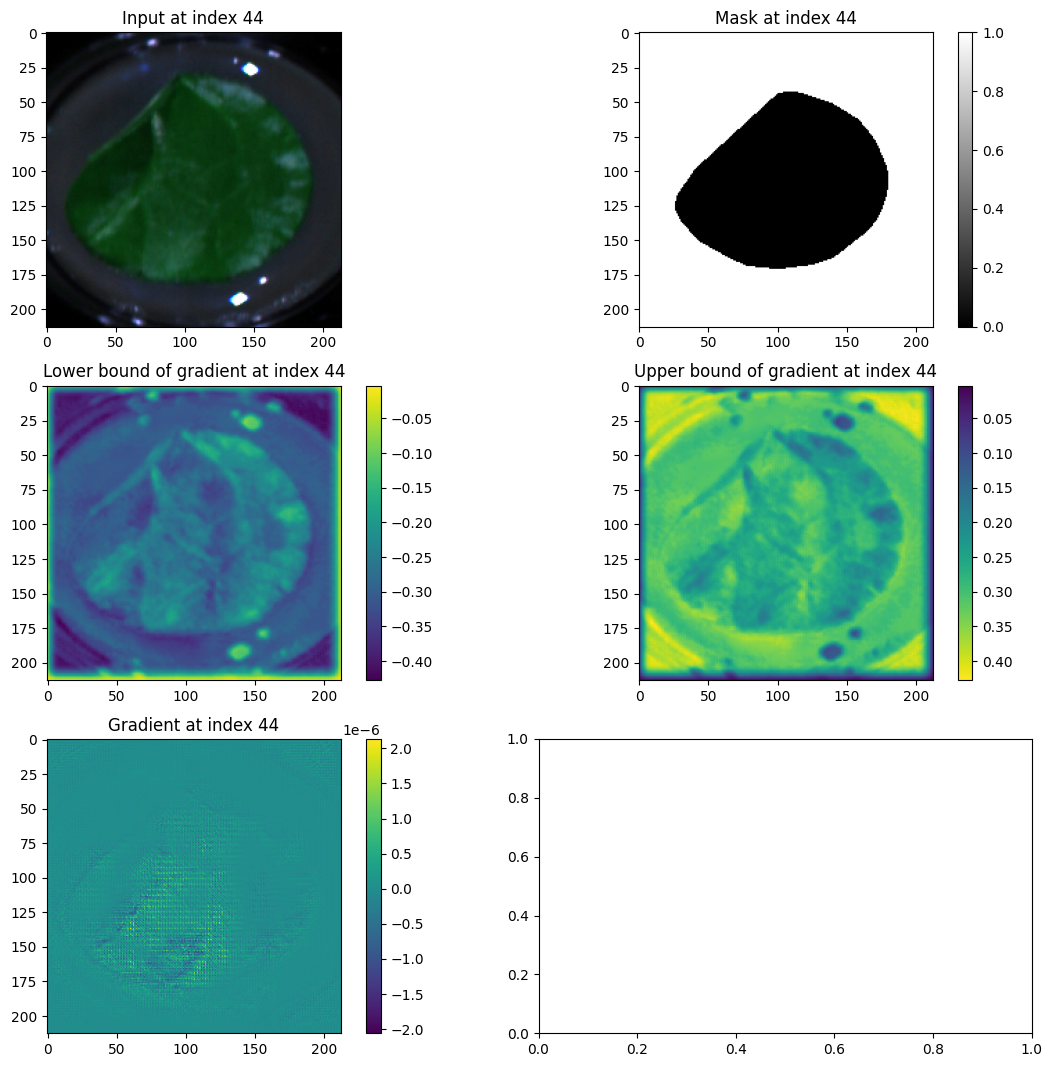

In [10]:
std_method = "std"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True)
    test_model_accuracy(curr_model, dl_test, device)
    dev0 = torch.device("cuda:0")
    test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", dev0, has_conv=True)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True, curr_device=device)

### RRR Training

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 5/5 [03:35<00:00, 43.03s/it, loss=0.493, reg=tensor(1.8532, device='cuda:1', grad_fn=<AddBackward0>)]


--- Model accuracy ---
Nominal = 0.87
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 175
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


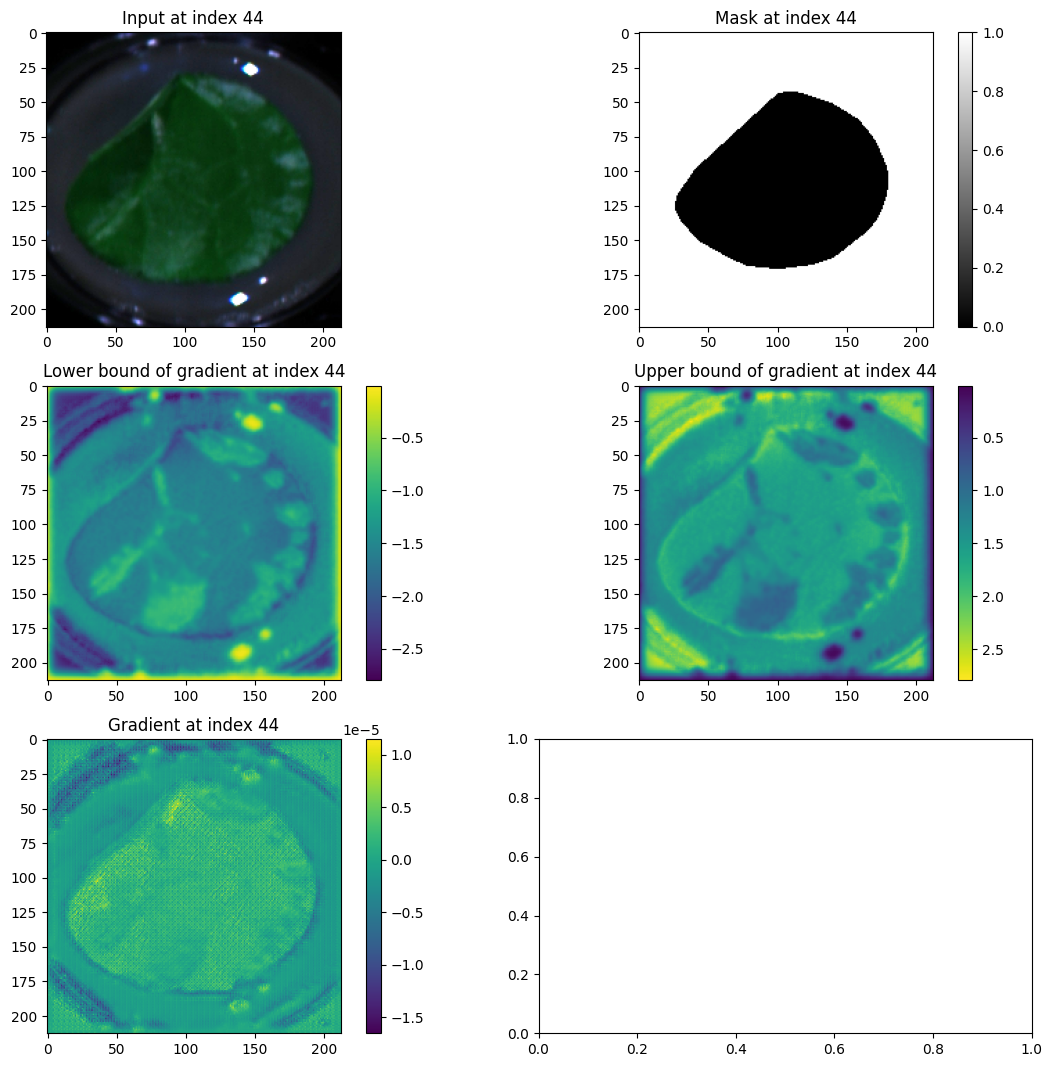

In [12]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method, 1e-2, device, True)
    test_model_accuracy(curr_model, dl_test, device)
    dev0 = torch.device("cuda:0")
    test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", dev0, has_conv=True)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, True, device)

========== Training model with method R4, restart 0 ==========


Epoch: 100%|██████████| 5/5 [03:56<00:00, 47.30s/it, loss=0.574, reg=tensor(0.0113, device='cuda:1', grad_fn=<DivBackward0>)]


--- Model accuracy ---
Nominal = 0.79
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 6.42
input lower bound shape: torch.Size([50, 3, 213, 213])
input upper bound shape: torch.Size([50, 3, 213, 213])
input gradient shape: torch.Size([50, 3, 213, 213])


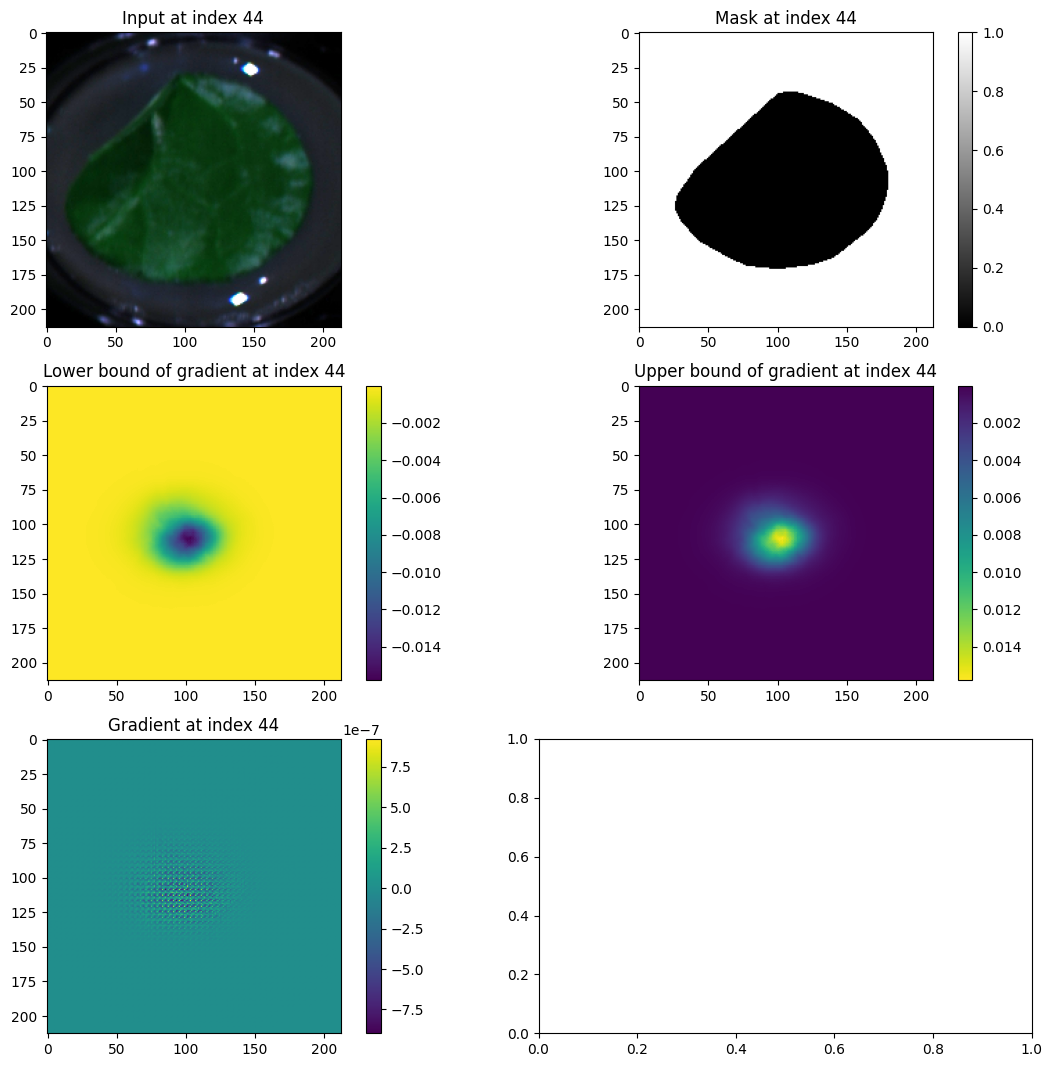

In [13]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, True)
    test_model_accuracy(curr_model, dl_test, device)
    dev0 = torch.device("cuda:0")
    test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", dev0, has_conv=True)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, True, device)

## PGD Training

### PGD_R4

In [ ]:
r4_pgd = "r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = PlantNet(3, 1)

    print(f"========== Training model with method {r4_pgd} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_pgd, 100, device)
    test_model_accuracy(curr_model, dl_test, device, multi_class=False)
    test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", device)
    dev0 = torch.device("cuda:0")
    test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM, "binary_cross_entropy", dev0, has_conv=True)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, True, device)